# Supervised analysis

## Table of Contents
- [Manually select features](#select)
- [Apply supervised learning techniques: Lasso, Ridge, Random Forest, Gradient Boosting](#model)
    - [Hypothesis Testing](#hypothesis)
    - [Ablation analysis](#ablation)
    - [Robustness checks](#robustness)
    - [Sensitivity analysis](#sensitivity)

In [1]:
from collections import defaultdict
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pyarrow.feather import read_feather, write_feather
from scipy.stats import f_oneway
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split

In [2]:
pd.set_option("display.max_columns", None)
df_all_features = read_feather("../data_cleaned/df_train.feather")
df_all_features

,category,date,year,quarter,total_deposits,gdp,cpi,unemployment_rate,fed_fund_rate,treasury_10yr_constant_maturity_rate,private_domestic_investment,private_domestic_investment_excl_iva_ccadj,fed_govt_expenditures,state_local_govt_expenditures,net_exports_good_services,housing_starts,new_one_family_houses_sold,case_shiller_us_national_home_price_index,advance_real_retail_food_services_sales,industrial_production_index,disposable_personal_income,retail_food_services_sales,personal_savings_rate,umich_consumer_sentiment_index,household_debt_service_payments_pct_disposable_income,credit_card_delinquency_rate,consumer_credit_owned_securitized_outstanding,cpi_urban_consumers_less_food_energy,avg_hrly_earnings_production_nonsupervisory_employees,real_median_household_income,pce,total_vehicle_sales,total_assets,total_interest_expense_quarterly,non_interest_expense_quarterly,debt_securities_maturity_1yr_or_less,net_income_quarterly
0,intermediate,2000-03-31,2000,1,-0.320456,-0.172706,-0.185839,-0.121974,0.560238,0.509916,-0.152421,-0.065298,-0.225582,-0.285041,0.224295,0.146654,0.125720,-0.245369,-0.086721,-0.053357,-0.188762,-0.105106,-0.040430,0.253748,0.039778,0.143002,-0.300376,-0.166460,-0.209258,-0.01463,NaN,0.120187,-0.339149,-0.072177,-0.281381,-0.237229,-0.241466
1,large,2000-03-31,2000,1,-0.313819,-0.172706,-0.185839,-0.121974,0.560238,0.509916,-0.152421,-0.065298,-0.225582,-0.285041,0.224295,0.146654,0.125720,-0.245369,-0.086721,-0.053357,-0.188762,-0.105106,-0.040430,0.253748,0.039778,0.143002,-0.300376,-0.166460,-0.209258,-0.01463,NaN,0.120187,-0.330829,-0.083550,-0.266007,-0.248587,-0.276004
2,small,2000-03-31,2000,1,-0.246853,-0.172706,-0.185839,-0.121974,0.560238,0.509916,-0.152421,-0.065298,-0.225582,-0.285041,0.224295,0.146654,0.125720,-0.245369,-0.086721,-0.053357,-0.188762,-0.105106,-0.040430,0.253748,0.039778,0.143002,-0.300376,-0.166460,-0.209258,-0.01463,NaN,0.120187,-0.258697,0.048691,-0.210623,-0.096685,-0.185958
3,intermediate,2000-06-30,2000,2,-0.318498,-0.161561,-0.177713,-0.135487,0.647394,0.409316,-0.119436,-0.018563,-0.220787,-0.278933,0.218864,0.142254,0.102682,-0.237248,-0.151762,-0.041247,-0.182477,-0.103936,-0.046680,0.228748,0.050737,0.154819,-0.293972,-0.163249,-0.204478,NaN,NaN,0.088630,-0.336330,-0.063662,-0.281358,-0.232071,-0.250755
4,large,2000-06-30,2000,2,-0.312659,-0.161561,-0.177713,-0.135487,0.647394,0.409316,-0.119436,-0.018563,-0.220787,-0.278933,0.218864,0.142254,0.102682,-0.237248,-0.151762,-0.041247,-0.182477,-0.103936,-0.046680,0.228748,0.050737,0.154819,-0.293972,-0.163249,-0.204478,NaN,NaN,0.088630,-0.328486,-0.072750,-0.266782,-0.257686,-0.250206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,large,2023-09-30,2023,3,0.469923,0.207049,0.259088,-0.155757,0.509780,0.095502,0.264359,NaN,0.287912,0.369981,-0.163571,0.065263,0.021328,0.426574,0.018970,0.059832,0.198734,0.192374,-0.043555,-0.107859,-0.096418,-0.072655,0.391716,0.249882,0.312422,NaN,0.172701,0.020799,0.486494,0.513867,0.315149,0.576274,0.647591
284,small,2023-09-30,2023,3,0.633448,0.207049,0.259088,-0.155757,0.509780,0.095502,0.264359,NaN,0.287912,0.369981,-0.163571,0.065263,0.021328,0.426574,0.018970,0.059832,0.198734,0.192374,-0.043555,-0.107859,-0.096418,-0.072655,0.391716,0.249882,0.312422,NaN,0.172701,0.020799,0.607077,0.777296,0.509721,0.470462,0.457277
285,intermediate,2023-12-31,2023,4,0.094317,0.215363,0.265523,-0.135487,0.541890,0.230637,0.266163,NaN,0.295290,0.371136,-0.167703,0.032267,-0.020428,0.434906,-0.046070,0.053851,0.200468,0.195843,-0.056055,-0.176609,-0.094555,-0.053453,0.391813,0.257734,0.321299,NaN,0.177315,-0.002959,0.064188,0.459715,0.043715,0.538189,-0.088474
286,large,2023-12-31,2023,4,0.483269,0.215363,0.265523,-0.135487,0.541890,0.230637,0.266163,NaN,0.295290,0.371136,-0.167703,0.032267,-0.020428,0.434906,-0.046070,0.053851,0.200468,0.195843,-0.056055,-0.176609,-0.094555,-0.053453,0.3918

<a id="select"></a>
# Manually select features

In [3]:
selected_features = [
    "cpi",
    "fed_fund_rate",
    "housing_starts",
    "personal_savings_rate",
    "umich_consumer_sentiment_index",
]
correlation_matrix = df_all_features[selected_features].corr()
correlation_matrix

,cpi,fed_fund_rate,housing_starts,personal_savings_rate,umich_consumer_sentiment_index
cpi,1.000000,-0.265044,-0.250698,0.287899,-0.404934
fed_fund_rate,-0.265044,1.000000,0.459629,-0.388953,0.306560
housing_starts,-0.250698,0.459629,1.000000,-0.182604,0.471492
personal_savings_rate,0.287899,-0.388953,-0.182604,1.000000,-0.087977
umich_consumer_sentiment_index,-0.404934,0.306560,0.471492,-0.087977,1.000000


Text(0.5, 1.0, 'Correlation between hand-picked metrics')

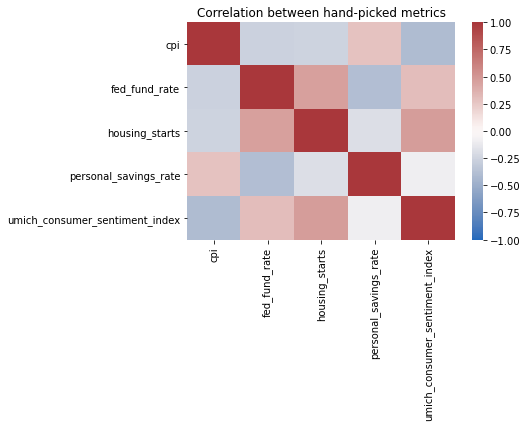

In [4]:
sns.heatmap(correlation_matrix, vmin=-1, vmax=1, cmap="vlag").set_title(
    "Correlation between hand-picked metrics"
)

In [5]:
# Create new dataframe with only the selected features
df = df_all_features.loc[
    :,
    [
        "category",
        "date",
        "year",
        "quarter",
        "total_deposits",
        "cpi",
        "fed_fund_rate",
        "housing_starts",
        "personal_savings_rate",
        "umich_consumer_sentiment_index",
    ],
]

In [6]:
# Shift total deposits to a quarter back so that other features are "predicting" it
lagged_df = df.groupby("category").apply(
    lambda x: x.assign(total_deposits_lag1=x["total_deposits"].shift(1))
)

lagged_df = lagged_df.dropna().reset_index(drop=True)
lagged_df

,category,date,year,quarter,total_deposits,cpi,fed_fund_rate,housing_starts,personal_savings_rate,umich_consumer_sentiment_index,total_deposits_lag1
0,intermediate,2000-06-30,2000,2,-0.318498,-0.177713,0.647394,0.142254,-0.046680,0.228748,-0.320456
1,intermediate,2000-09-30,2000,3,-0.317991,-0.172838,0.726905,0.070543,-0.034180,0.220712,-0.318498
2,intermediate,2000-12-31,2000,4,-0.316565,-0.168938,0.722318,0.108378,-0.046680,0.198391,-0.317991
3,intermediate,2001-03-31,2001,1,-0.310366,-0.165362,0.641278,0.130816,-0.040430,0.099284,-0.316565
4,intermediate,2001-06-30,2001,2,-0.309818,-0.159512,0.460850,0.152373,-0.031055,0.043034,-0.310366
...,...,...,...,...,...,...,...,...,...,...,...
280,small,2022-12-31,2022,4,0.604724,0.234129,0.197853,0.056904,-0.087305,-0.211430,0.601781
281,small,2023-03-31,2023,1,0.617267,0.237893,0.388984,0.016429,-0.043555,-0.166788,0.604724
282,small,2023-06-30,2023,2,0.623736,0.251521,0.465437,0.019949,-0.018555,-0.177502,0.617267
283,small,2023-09-30,2023,3,0.633448,0.259088,0.509780,0.065263,-0.043555,-0.107859,0.623736


<a id="model"></a>
# Apply supervised learning techniques: Lasso, Ridge, Random Forest, Gradient Boosting

In [7]:
random_state = 42

In [8]:
def run_sklearn_model(lagged_df, selected_features, model, param_grid, cv=3):
    """
    Run a sklearn model for each category using future importance, evaluate the models, and pick a best model for each category after grid search.

    Args:
    - lagged_df (DataFrame): where 'total_deposits' is response variable
    - selected_features (list): list of most independent features in the model
    - model: a sklearn model, e.g. Lasso
    - param_grid (dict): param_grid to pass into GridSearchCV

    Returns:
    - dict: Dictionary containing the best model for each category and their evaluation metrics.
    """

    categories = lagged_df["category"].unique()
    best_models = {}

    for category in categories:
        X = lagged_df[lagged_df["category"] == category][selected_features]
        y = lagged_df[lagged_df["category"] == category]["total_deposits"]

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=random_state
        )

        grid_search = GridSearchCV(
            model, param_grid, cv=cv, scoring="neg_mean_squared_error"
        )
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)

        best_models[category] = {"model": best_model, "rmse": rmse, "r2": r2}

    return best_models

In [9]:
grid_lasso = {"alpha": np.logspace(-4, 2, 10)}
best_models_lasso = run_sklearn_model(
    lagged_df, selected_features, Lasso(max_iter=10000), grid_lasso, cv=5
)
best_models_lasso

{'intermediate': {'model': Lasso(alpha=0.00046415888336127773, max_iter=10000),
  'rmse': 0.019425790051899944,
  'r2': 0.9704935730535077},
 'large': {'model': Lasso(alpha=0.0001, max_iter=10000),
  'rmse': 0.032963254440566886,
  'r2': 0.9827818068179015},
 'small': {'model': Lasso(alpha=0.00046415888336127773, max_iter=10000),
  'rmse': 0.04331354158760944,
  'r2': 0.9598590525877293}}

In [10]:
grid_ridge = {"alpha": [0.01, 0.1, 1, 10]}
best_models_ridge = run_sklearn_model(lagged_df, selected_features, Ridge(), grid_ridge)
best_models_ridge

{'intermediate': {'model': Ridge(alpha=0.01),
  'rmse': 0.016443816572767476,
  'r2': 0.9788571032893162},
 'large': {'model': Ridge(alpha=0.01),
  'rmse': 0.032946141224715314,
  'r2': 0.9827996801847124},
 'small': {'model': Ridge(alpha=0.01),
  'rmse': 0.04382670326311266,
  'r2': 0.9589022701009735}}

In [11]:
grid_forest = {"n_estimators": [50, 100, 150], "max_depth": [None, 10, 20]}
best_models_random_forest = run_sklearn_model(
    lagged_df,
    selected_features,
    RandomForestRegressor(random_state=random_state),
    grid_forest,
)
best_models_random_forest

{'intermediate': {'model': RandomForestRegressor(n_estimators=50, random_state=42),
  'rmse': 0.007504145632542519,
  'r2': 0.9955968675626676},
 'large': {'model': RandomForestRegressor(max_depth=10, random_state=42),
  'rmse': 0.011183713533819499,
  'r2': 0.9980180190350637},
 'small': {'model': RandomForestRegressor(n_estimators=50, random_state=42),
  'rmse': 0.025261424113287353,
  'r2': 0.9863461261059296}}

In [12]:
grid_boost = {
    "n_estimators": [50, 100, 150],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.05, 0.1, 0.2],
}
best_models_gradient_boosting = run_sklearn_model(
    lagged_df,
    selected_features,
    GradientBoostingRegressor(random_state=random_state),
    param_grid=grid_boost,
)
best_models_gradient_boosting

{'intermediate': {'model': GradientBoostingRegressor(n_estimators=50, random_state=42),
  'rmse': 0.012661302273951541,
  'r2': 0.9874652408043725},
 'large': {'model': GradientBoostingRegressor(learning_rate=0.05, n_estimators=150, random_state=42),
  'rmse': 0.014572214918471665,
  'r2': 0.9966350505356601},
 'small': {'model': GradientBoostingRegressor(learning_rate=0.05, random_state=42),
  'rmse': 0.02788864514040002,
  'r2': 0.9833584007489687}}

In [13]:
categories = lagged_df["category"].unique()


def plot_error_chart(error_values, title, xlab, ylab):
    """
    Plots an error chart with given title, and labels.

    Args:
    - error_values (Dict): where each key is the name of a model type, and each value is a list of its errors per category
    - title (str): chart title
    - xlab (str): chart x-label
    - ylab (str): chart y-label
    """

    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.2
    index = range(len(categories))

    for i, (method, error) in enumerate(error_values.items()):
        ax.bar([x + i * bar_width for x in index], error, bar_width, label=method)

    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    ax.set_xticks([x + bar_width for x in index])
    ax.set_xticklabels(categories)
    ax.legend()

    plt.tight_layout()
    plt.show()

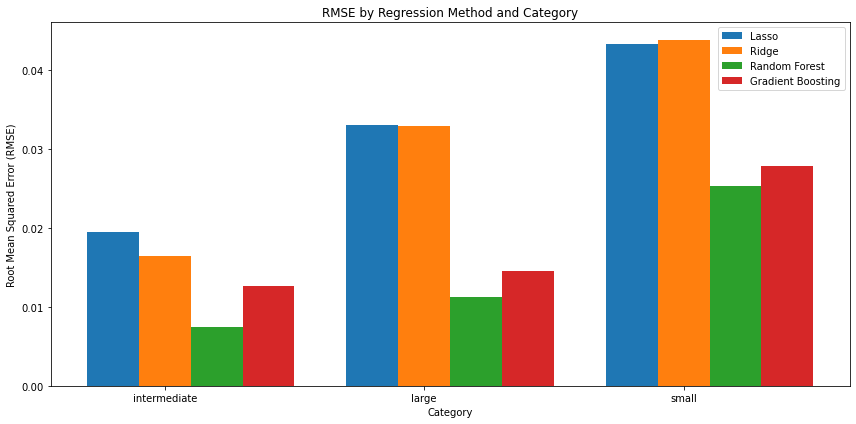

In [14]:
# Results from the four regression methods for "rmse"
rmse_values = {
    "Lasso": [best_models_lasso[cat]["rmse"] for cat in categories],
    "Ridge": [best_models_ridge[cat]["rmse"] for cat in categories],
    "Random Forest": [best_models_random_forest[cat]["rmse"] for cat in categories],
    "Gradient Boosting": [
        best_models_gradient_boosting[cat]["rmse"] for cat in categories
    ],
}

plot_error_chart(
    rmse_values,
    "RMSE by Regression Method and Category",
    "Category",
    "Root Mean Squared Error (RMSE)",
)

#### Conclusion
"Random Forest" is best performing model for every category, but other models also perform reasonably well.

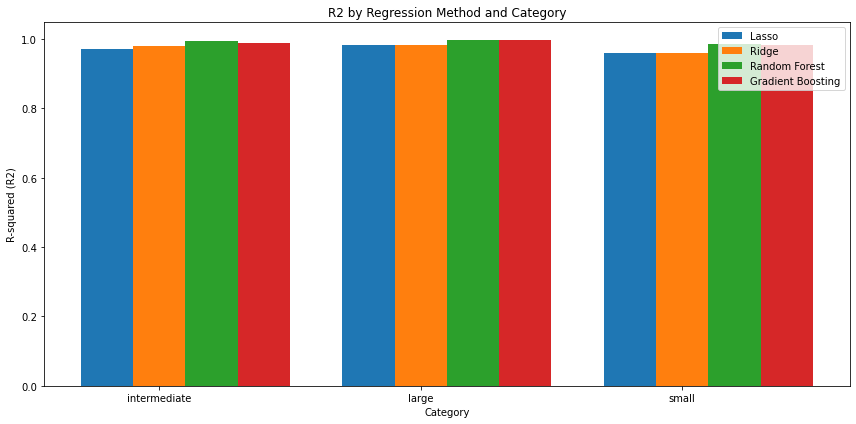

In [15]:
# Results from the four regression methods for "r2"
r2_values = {
    "Lasso": [best_models_lasso[cat]["r2"] for cat in categories],
    "Ridge": [best_models_ridge[cat]["r2"] for cat in categories],
    "Random Forest": [best_models_random_forest[cat]["r2"] for cat in categories],
    "Gradient Boosting": [
        best_models_gradient_boosting[cat]["r2"] for cat in categories
    ],
}

plot_error_chart(
    r2_values, "R2 by Regression Method and Category", "Category", "R-squared (R2)"
)

#### Conclusion
There isn't a significant difference in r2 score between models and categories.

<a id="hypothesis"></a>
## Hypothesis Testing

### Hypothesis I
Our hypothesis states that warning signs can be identified in deposit data that indicate potential changes in non-maturity deposit levels. (Null hypothesis: deposit fluctuations are random and cannot be predicted based on historical data.)

To test the hypothesis, we can compare the evaluation metric (e.g., RMSE) of models with a baseline model (e.g., a model that predicts deposit fluctuations are random). If the evaluation metric of such as the Lasso regression or other model is significantly lower than the baseline model, it provides evidence to reject the null hypothesis.

A suitable baseline model might be a model that simply predicts the average deposit change or no change in deposits over time. This model assumes that deposit fluctuations are random and cannot be predicted, providing a benchmark for comparison with the Lasso regression or other models.

In [16]:
def calculate_baseline_rmse(lagged_df, category):
    """
    Calculate the baseline RMSE for a given category.

    Args:
    - lagged_df (DataFrame): DataFrame containing the lagged data.
    - category (str): Category for which to calculate the baseline RMSE.

    Returns:
    - float: Baseline RMSE for the given category.
    """
    category_df = lagged_df[lagged_df["category"] == category]
    # Calculate the baseline prediction
    baseline_prediction = category_df["total_deposits"].mean()
    baseline_rmse = mean_squared_error(
        category_df["total_deposits"],
        [baseline_prediction] * len(category_df),
        squared=False,
    )
    return baseline_rmse


for cat in lagged_df["category"].unique():
    baseline_rmse = calculate_baseline_rmse(lagged_df, cat)
    print(f"Category: {cat}")
    print(f"Baseline RMSE: {baseline_rmse}")
    print()

Category: intermediate
Baseline RMSE: 0.12689349643656198

Category: large
Baseline RMSE: 0.26672778661478974

Category: small
Baseline RMSE: 0.2634718272800676



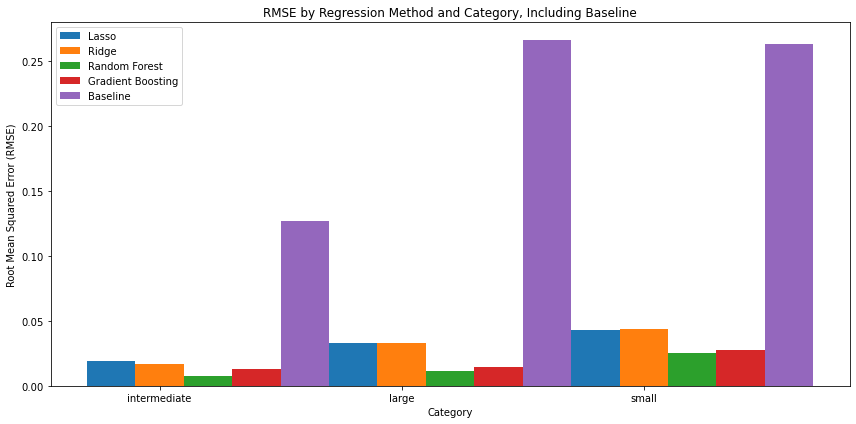

In [17]:
mse_values = {
    "Lasso": [best_models_lasso[cat]["rmse"] for cat in categories],
    "Ridge": [best_models_ridge[cat]["rmse"] for cat in categories],
    "Random Forest": [best_models_random_forest[cat]["rmse"] for cat in categories],
    "Gradient Boosting": [
        best_models_gradient_boosting[cat]["rmse"] for cat in categories
    ],
    "Baseline": [calculate_baseline_rmse(lagged_df, cat) for cat in categories],
}

plot_error_chart(
    mse_values,
    "RMSE by Regression Method and Category, Including Baseline",
    "Category",
    "Root Mean Squared Error (RMSE)",
)

#### Conclusion
The evaluation metrics of models are significantly lower than the baseline model, it provides evidence to reject the null hypothesis which means deposit fluctuations are not random and can be predicted based on historical data

#### Hypothesis II
Our hypothesis states that there are significant differences in deposit trends among different categories of banks by asset size.
(Null hypothesis: there are no significant differences between these categories).

To test this hypothesis, we can use ANOVA (Analysis of Variance) to determine if there are significant differences in deposit trends among different categories of banks by asset size.

Pairwise Comparison: ('intermediate', 'large'), p-value: 8.115705884721611e-13, Decision: Reject null hypothesis
Pairwise Comparison: ('intermediate', 'small'), p-value: 1.5090431956001103e-09, Decision: Reject null hypothesis
Pairwise Comparison: ('large', 'small'), p-value: 0.27406318703156457, Decision: Fail to reject null hypothesis


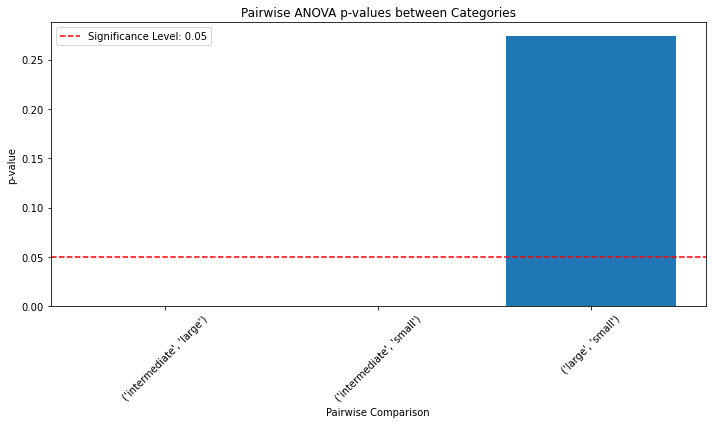

In [18]:
def pairwise_anova(lagged_df):
    """
    Perform pairwise ANOVA comparisons between categories.

    Args:
    - lagged_df (DataFrame): DataFrame containing the lagged data.

    Returns:
    - DataFrame: DataFrame containing pairwise ANOVA p-values.
    """
    categories = lagged_df["category"].unique()
    pairwise_comparisons = list(combinations(categories, 2))

    p_values = []
    for cat1, cat2 in pairwise_comparisons:
        data_cat1 = lagged_df[lagged_df["category"] == cat1]["total_deposits"]
        data_cat2 = lagged_df[lagged_df["category"] == cat2]["total_deposits"]
        result = f_oneway(data_cat1, data_cat2)
        p_values.append(result.pvalue)

    pairwise_anova_results = pd.DataFrame(
        {"Pairwise Comparison": pairwise_comparisons, "p-value": p_values}
    )

    for i, row in pairwise_anova_results.iterrows():
        if row["p-value"] < 0.05:
            decision = "Reject null hypothesis"
        else:
            decision = "Fail to reject null hypothesis"
        print(
            f"Pairwise Comparison: {row['Pairwise Comparison']}, p-value: {row['p-value']}, Decision: {decision}"
        )

    return pairwise_anova_results


pairwise_anova_results = pairwise_anova(lagged_df)

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(
    range(len(pairwise_anova_results)),
    pairwise_anova_results["p-value"],
    tick_label=pairwise_anova_results["Pairwise Comparison"],
)
ax.axhline(y=0.05, color="r", linestyle="--", label="Significance Level: 0.05")
ax.set_xlabel("Pairwise Comparison")
ax.set_ylabel("p-value")
ax.set_title("Pairwise ANOVA p-values between Categories")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Conclusion
For the large vs intermediate and intermediate vs small: p-value is less than the significance level (e.g., 0.05), therefore we reject the null hypothesis, and conclude that there are significant differences in deposit trends among different categories of banks by asset size. However, it's opposite for large vs small categories.

This pattern could indicate that there are distinct differences in deposit trends between adjacent categories (e.g., "large" vs "intermediate" and "intermediate" vs "small"), but the differences between non-adjacent categories (e.g., "large" vs "small") are not as pronounced. This could be due to specific characteristics or behaviors that are more similar between the "large" and "small" categories compared to the other pairwise comparisons. Large vs small banks having similar values is unintuitive and may warrant further analysis.

<a id="ablation"></a>
## Ablation analysis

Ablation analysis refers to a technique used to understand the importance of different features (predictors) in the predictive model. It involves systematically removing one feature at a time from the model and observing how it affects the model's performance. By doing so, we can identify which features have the most significant impact on the model's predictions.

In [19]:
ablation_results = []

model_functions = {
    "Lasso": (Lasso(max_iter=10000), grid_lasso, 5),
    "Ridge": (Ridge(), grid_ridge, 3),
    "Random Forest": (RandomForestRegressor(random_state=random_state), grid_forest, 3),
    "Gradient Boosting": (
        GradientBoostingRegressor(random_state=random_state),
        grid_boost,
        3,
    ),
}

for feature in selected_features:
    features_without_current = [f for f in selected_features if f != feature]
    model_results = {}

    for model_name, (model, param_grid, cv) in model_functions.items():
        best_models = run_sklearn_model(
            lagged_df, features_without_current, model, param_grid, cv
        )
        top_models = sorted(best_models.items(), key=lambda x: x[1]["rmse"])[:3]
        model_results[model_name] = top_models

    ablation_results.append({"feature_excluded": feature, "results": model_results})

In [20]:
ablation_df_rows = []
for result in ablation_results:
    feature = result["feature_excluded"]
    features_in_use = ", ".join([f for f in selected_features if f != feature])
    for model_name, top_models in result["results"].items():
        for rank, (category, metrics) in enumerate(top_models, start=1):
            ablation_df_rows.append(
                {
                    "feature_excluded": feature,
                    "features_in_use": features_in_use,
                    "model": model_name,
                    "rank": rank,
                    "category": category,
                    "rmse": metrics["rmse"],
                }
            )

ablation_df = pd.DataFrame(ablation_df_rows).sort_values(
    by=["model", "category", "feature_excluded"]
)

idx = ablation_df.groupby(["category", "model"])["rmse"].idxmax()
ablation_df_stylized = ablation_df.style.apply(
    lambda x: ["background-color: yellow" if x.name in idx.values else "" for i in x],
    axis=1,
)
ablation_df_stylized

,feature_excluded,features_in_use,model,rank,category,rmse
10,cpi,"fed_fund_rate, housing_starts, personal_savings_rate, umich_consumer_sentiment_index",Gradient Boosting,2,intermediate,0.086726
21,fed_fund_rate,"cpi, housing_starts, personal_savings_rate, umich_consumer_sentiment_index",Gradient Boosting,1,intermediate,0.011545
33,housing_starts,"cpi, fed_fund_rate, personal_savings_rate, umich_consumer_sentiment_index",Gradient Boosting,1,intermediate,0.015657
45,personal_savings_rate,"cpi, fed_fund_rate, housing_starts, umich_consumer_sentiment_index",Gradient Boosting,1,intermediate,0.013372
57,umich_consumer_sentiment_index,"cpi, fed_fund_rate, housing_starts, personal_savings_rate",Gradient Boosting,1,intermediate,0.007785
11,cpi,"fed_fund_rate, housing_starts, personal_savings_rate, umich_consumer_sentiment_index",Gradient Boosting,3,large,0.111934
22,fed_fund_rate,"cpi, housing_starts, personal_savings_rate, umich_consumer_sentiment_index",Gradient Boosting,2,large,0.015507
34,housing_starts,"cpi, fed_fund_rate, personal_savings_rate, umich_consumer_sentiment_index",Gradient Boosting,2,large,0.017410
46,personal_savings_rate,"cpi, fed_fund_rate, housing_starts, umich_consumer_sentiment_index",Gradient Boosting,2,large,0.013571
58,umich_consumer_sentiment_index,"cpi, fed_fund_rate, housing_starts, personal_savings_rate",Gradient Boosting,2,large,0.013994


#### Conclusion

Based on this analysis, CPI is the most valuable feature across all models and bank categories (small, medium, large).

<a id="robustness"></a>

## Robustness checks

We conducted robustness checks to assess how effectively our models predict a bank's non-maturity deposits in specific categories using unseen data. This evaluation involved eight banks: one large, two intermediate, and five small banks. For each bank, we determined the best-performing model using the previously trained category-based models. Finally, we visualized the results based on RMSE.

We do robustness checks on two models:

- ridge regression, because it is the best performing of our two regression models (which are valuable for being easily interpretable).
- random forest, because it is our best performing model.

In [21]:
# Prepare sample data in the same way as training data

df_samples = read_feather("../data_cleaned/df_samples.feather")
df_samples = df_samples.loc[
    :,
    [
        "category",
        "name",
        "date",
        "year",
        "quarter",
        "total_deposits",
        "cpi",
        "fed_fund_rate",
        "housing_starts",
        "personal_savings_rate",
        "umich_consumer_sentiment_index",
    ],
]

lagged_df_samples = df_samples.groupby("category").apply(
    lambda x: x.assign(total_deposits_lag1=x["total_deposits"].shift(1))
)
lagged_df_samples = lagged_df_samples.dropna().reset_index(drop=True)

In [22]:
# Conduct robustness checks

def test_robustness(lagged_df_samples, selected_features, best_model):
    """
    Tests model robustness on sample df.

    Args:
    - lagged_df_samples (DataFrame): DataFrame containing sample data.
    - selected_features (list): List of selected features.
    - best_model (Dict): Output of run_sklearn_model function.

    Returns:
    - dict: Dictionary containing rmse and r2 for each category.
    """
    model_results = {}

    for bank_name, bank_data in lagged_df_samples.groupby("name"):
        model = best_model[bank_data.iloc[0]["category"]]["model"]

        test_X = bank_data[selected_features]
        test_y = bank_data["total_deposits"]

        predictions = model.predict(test_X)
        rmse = mean_squared_error(test_y, predictions, squared=False)
        r2 = r2_score(test_y, predictions)
        category = bank_data.iloc[0]["category"]

        if category not in model_results:
            model_results[category] = []

        model_results[category].append({
            "bank_name": bank_name,
            "rmse": rmse,
            "r2": r2,
        })

    return model_results

robustness_ridge = test_robustness(lagged_df_samples, selected_features, best_models_ridge)
robustness_random_forest = test_robustness(lagged_df_samples, selected_features, best_models_random_forest)

print("Ridge Results:")
for category, results in robustness_ridge.items():
    print(f"Category: {category}")
    for result in results:
        print(f"Bank: {result['bank_name']}, RMSE: {result['rmse']}, R-squared: {result['r2']}")
    print()

print("\nRandom Forest Results:")
for category, results in robustness_random_forest.items():
    print(f"Category: {category}")
    for result in results:
        print(f"Bank: {result['bank_name']}, RMSE: {result['rmse']}, R-squared: {result['r2']}")
    print()

Ridge Results:
Category: large
Bank: BANK OF AMERICA CORP, RMSE: 0.2972553716693558, R-squared: -9.357956213919069

Category: small
Bank: BK JAMES FINL GROUP INC, RMSE: 0.5226222868066792, R-squared: -651700842.7685858
Bank: CENTRE 1 BCORP INC, RMSE: 0.4811313232125608, R-squared: -288937064.4704116
Bank: GREAT OAKS FINL HOLDINGS INC, RMSE: 0.8870483626412559, R-squared: -71102227750.61662
Bank: OHNWARD BANCSHARES INC, RMSE: 0.4784928722326434, R-squared: -44940241.64333157
Bank: PEOPLES BCORP OF NC INC, RMSE: 0.4786131164135999, R-squared: -363983698.2836025

Category: intermediate
Bank: CHARLES SCHWAB CORP THE, RMSE: 0.24487289419323818, R-squared: -417.18676153936593
Bank: TORONTO-DOMINION BANK THE, RMSE: 0.2306218312266531, R-squared: -405.37382042433507


Random Forest Results:
Category: large
Bank: BANK OF AMERICA CORP, RMSE: 0.2986762894117881, R-squared: -9.457217533540895

Category: small
Bank: BK JAMES FINL GROUP INC, RMSE: 0.522495716506573, R-squared: -651385219.0950378
Ban

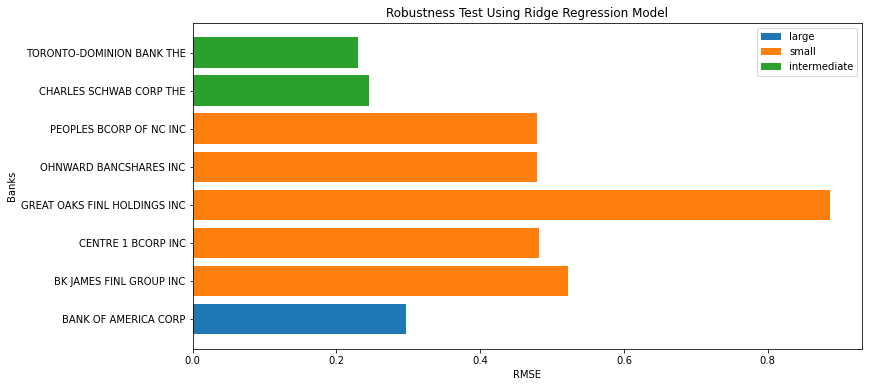

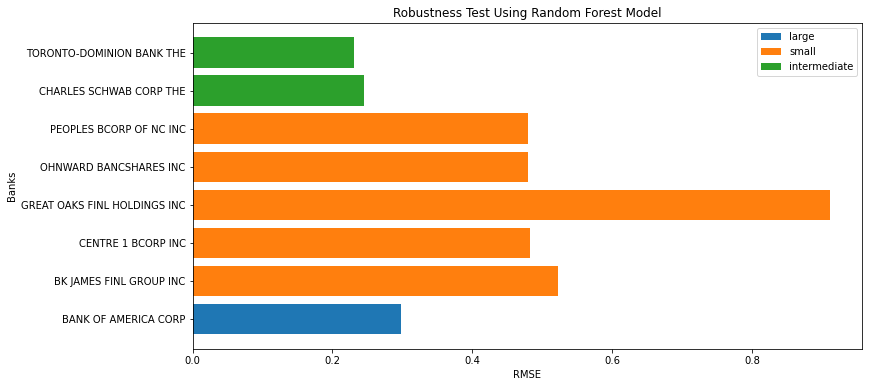

In [23]:
# Plot bar chart for robustness checks results

def plot_bar_chart(results, model_name):
    plt.figure(figsize=(12, 6))
    for category, banks in results.items():
        df = pd.DataFrame(banks)
        df = df.set_index('bank_name')  # Set bank_name as the index
        plt.barh(df.index, df['rmse'], label=category)
    plt.xlabel('RMSE')
    plt.ylabel('Banks')
    plt.title(f'{model_name} Model')
    plt.legend()
    plt.show()

# Plotting the results for Ridge Regression
plot_bar_chart(robustness_ridge, 'Robustness Test Using Ridge Regression')

# Plotting the results for Random Forest
plot_bar_chart(robustness_random_forest, 'Robustness Test Using Random Forest')

### Conclusion

Both models perform comparably well on the sample data. They are substantially less effective on individual sample banks, especially smaller banks. This can be explained by the large variance in bank structures.

<a id="sensitivity"></a>

## Sensitivity analysis

We do sensitivity analysis on the random forest and ridge regression models only, for the same reasons as for robustness checks.

In [24]:
def test_single_model(model, X_train, X_test, y_train, y_test, init_dict):
    """
    Runs a single model to check results for sensitivity analysis.
    Args:
    - model: sklearn model to train and evaluate
    - X_train, X_test, y_train, y_test (DataFrame): to use for model training and evaluation
    - init_dict (dict): dictionary that output appends rmse and r2 values to

    Returns:
    - dict: Dictionary containing category, feature,
    """
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    r2 = r2_score(y_test, predictions)
    init_dict["RMSE"] = rmse
    init_dict["r2"] = r2
    return init_dict

In [25]:
sensitivity_results = []

for category in categories:
    df_cat = lagged_df[lagged_df["category"] == category]
    X = df_cat[selected_features]
    y = df_cat["total_deposits"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )

    # Random forest
    for n_estimators in [50, 100, 150, 200, 250]:
        init_dict = {
            "category": category,
            "model": "random_forest",
            "parameter": "n_estimators",
            "value": n_estimators,
        }
        model = RandomForestRegressor(
            n_estimators=n_estimators, max_depth=10, random_state=random_state
        )
        model_results = test_single_model(
            model, X_train, X_test, y_train, y_test, init_dict
        )
        sensitivity_results.append(model_results)

    for max_depth in [1, 5, 10, 20, 30, None]:
        init_dict = {
            "category": category,
            "model": "random_forest",
            "parameter": "max_depth",
            "value": max_depth,
        }
        model = RandomForestRegressor(
            n_estimators=100, max_depth=max_depth, random_state=random_state
        )
        model_results = test_single_model(
            model, X_train, X_test, y_train, y_test, init_dict
        )
        sensitivity_results.append(model_results)

    # Ridge regression
    for alpha in np.logspace(-4, 2, 10):
        init_dict = {
            "category": category,
            "model": "ridge",
            "parameter": "alpha",
            "value": alpha,
        }
        model = Ridge(alpha=alpha, max_iter=10000)
        model_results = test_single_model(
            model, X_train, X_test, y_train, y_test, init_dict
        )
        sensitivity_results.append(model_results)

sensitivity_results_tb = pd.DataFrame(sensitivity_results).sort_values(
    by=["model", "parameter", "category"]
)
sensitivity_results_tb

,category,model,parameter,value,RMSE,r2
5,intermediate,random_forest,max_depth,1.000000,0.051666,0.791277
6,intermediate,random_forest,max_depth,5.000000,0.007347,0.995780
7,intermediate,random_forest,max_depth,10.000000,0.007809,0.995232
8,intermediate,random_forest,max_depth,20.000000,0.007866,0.995162
9,intermediate,random_forest,max_depth,30.000000,0.007866,0.995162
...,...,...,...,...,...,...
58,small,ridge,alpha,0.215443,0.059420,0.924455
59,small,ridge,alpha,1.000000,0.117078,0.706712
60,small,ridge,alpha,4.641589,0.182761,0.285329
61,small,ridge,alpha,21.544347,0.216602,-0.003846


In [26]:
def plot_sensitivity_results(results_df, xscale="", ticks=[], labels=[]):
    """
    Plots sensitivity results given corresponding table of a model and parameter.
    Args:
    - results_df (DataFrame): sensitivity analysis results
    - xscale (str): xscale value; ignored if empty string
    - ticks [list]: xtick locations; ignored if either ticks or labels are empty
    - labels [list]: xtick labels; ignored if either ticks or labels are empty
    """
    parameter = results_df.reset_index()["parameter"][0]
    for i in categories:
        sns.lineplot(
            data=results_df[results_df["category"] == i],
            x="value",
            y="RMSE",
            marker="o",
            label="RMSE vs " + parameter + " (" + i + ")",
        )
    if len(xscale) > 0:
        plt.xscale(xscale)
    if (len(ticks) > 0) and (len(labels) > 0):
        plt.xticks(ticks=ticks, labels=labels)
    plt.title("Change in RMSE based on adjustments to " + parameter)
    plt.xlabel(parameter)
    plt.legend()
    plt.show()

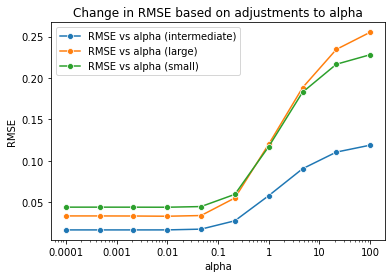

In [27]:
plot_sensitivity_results(
    sensitivity_results_tb[
        (sensitivity_results_tb["model"] == "ridge")
        & (sensitivity_results_tb["parameter"] == "alpha")
    ],
    xscale="log",
    ticks=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    labels=["0.0001", "0.001", "0.01", "0.1", "1", "10", "100"],
)

For the ridge regression, alpha is optimal at up to 0.01. Further increment decreases the accuracy of the model.

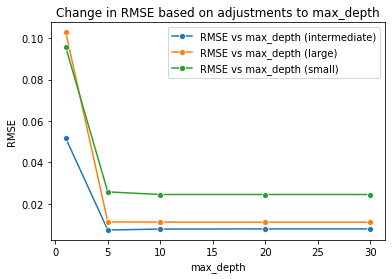

In [28]:
plot_sensitivity_results(
    sensitivity_results_tb[
        (sensitivity_results_tb["model"] == "random_forest")
        & (sensitivity_results_tb["parameter"] == "max_depth")
    ]
)

For random forest, the model is no longer sensitive to changes once max_depth > 5 across all bank sizes.

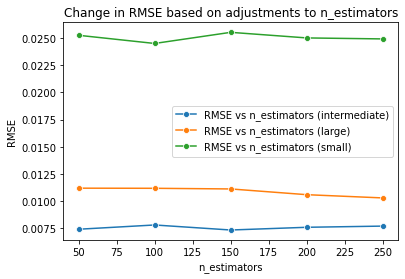

In [29]:
plot_sensitivity_results(
    sensitivity_results_tb[
        (sensitivity_results_tb["model"] == "random_forest")
        & (sensitivity_results_tb["parameter"] == "n_estimators")
    ]
)

For random forest, there does not appear to be a uniform pattern across all three categories in performance from number of estimators. This may be explained by the substantial difference in number of available banks in different categories.